In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
from MakePlots import *
import os
import random
from scipy import stats
from itertools import groupby,combinations
from scipy.optimize import curve_fit
from scipy.stats import t
import statsmodels.api as sm

In [ ]:
analysis_dir = Path('AnalysisAndFigures-Final')
figure_dir = analysis_dir/'SpecializedPlots'
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

operator_for_average = '75pct'

patient_key = pd.read_excel('PatientKey.xlsx')
family1_df = pd.read_csv(analysis_dir/'Rank_Ordered_Barplots'/operator_for_average/f'3.1.0_{operator_for_average}_Family_Clusters_Renamed.tsv',
                        delimiter='\t')

In [10]:
# Make plot showing the proband and the sister standard deviation vs telomere length
probands_and_sister = patient_key[patient_key['SiblingGroup']==1]['Sample'].tolist()
proband_sister_dataframe = []
for sample_id in probands_and_sister:
    rel_cols = [x for x in family1_df.columns if sample_id in x] + ['plot_allele_id']
    sample_dataframe = family1_df[rel_cols].dropna(subset=f'{sample_id}_tvr_consensus')
    sample_dataframe[f'{sample_id}_total_tel_len'] = sample_dataframe.apply(lambda x: get_tel_len_list(x[f'{sample_id}_read_TLs'],True,x[f'{sample_id}_tvr_len']),axis=1)
    sample_dataframe[f'{sample_id}_{operator_for_average}_tel_len'] = sample_dataframe[f'{sample_id}_total_tel_len'].apply(lambda x: find_average(x,operator_for_average))
    sample_dataframe[f'{sample_id}_{operator_for_average}_tel_std_dev'] = sample_dataframe[f'{sample_id}_total_tel_len'].apply(lambda x: np.std(x))
    sample_dataframe.set_index('plot_allele_id',inplace=True)
    proband_sister_dataframe.append(sample_dataframe)
proband_sister_dataframe = pd.concat(proband_sister_dataframe,axis=1)
proband_sister_dataframe.reset_index(inplace=True)

In [11]:
plot_proband_sister_std = []
for sample_id in probands_and_sister:
    rel_cols = [x for x in proband_sister_dataframe.columns if sample_id in x] + ['plot_allele_id']
    sample_dataframe = proband_sister_dataframe[rel_cols].dropna(subset=f'{sample_id}_tvr_consensus')
    tdf=pd.DataFrame()
    tdf['plot_allele_id'] = sample_dataframe['plot_allele_id'].tolist()
    tdf['figure_name'] = patient_key[patient_key.Sample==sample_id]['FigureName'].item()
    tdf['sample_id'] = sample_id
    tdf[f'{operator_for_average}_tel_len'] = sample_dataframe[f'{sample_id}_{operator_for_average}_tel_len'].tolist()
    tdf[f'{operator_for_average}_tel_std_dev'] = sample_dataframe[f'{sample_id}_{operator_for_average}_tel_std_dev'].tolist()
    plot_proband_sister_std.append(tdf)
plot_proband_sister_std = pd.concat(plot_proband_sister_std)
xmin = plot_proband_sister_std[f'{operator_for_average}_tel_len'].min()
xmax = plot_proband_sister_std[f'{operator_for_average}_tel_len'].max()
ymin = plot_proband_sister_std[f'{operator_for_average}_tel_std_dev'].min()
ymax = plot_proband_sister_std[f'{operator_for_average}_tel_std_dev'].max()

In [12]:
def exponential_func(x, a, b, c):
        return a * b**x + c

def quadratic_function(x, a, b, c):
        return a * x**2 + b * x + c

def square_function():
        return

Fitted parameters: a=0.00, b=-0.07, c=1552.55
[3.10067056e-06 5.45898445e-02 2.26926372e+02]


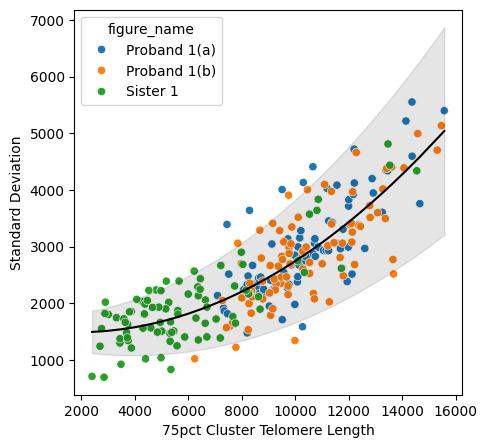

In [13]:
file_prefix = 'fam1_proband_sister_std_dev_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass

# plot the standard deviation for the proband and sister
x_string = f'{operator_for_average}_tel_len'
y_string = f'{operator_for_average}_tel_std_dev'

x_data = plot_proband_sister_std.sort_values(by=x_string)[x_string].tolist()
y_data = plot_proband_sister_std.sort_values(by=x_string)[y_string].tolist()
popt, pcov = curve_fit(quadratic_function, x_data, y_data, p0=(0, 2, 1000))

a_fit, b_fit, c_fit = popt
print(f"Fitted parameters: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}")

# draw the confidence interval based on the error of the covariance matrix
perr = np.sqrt(np.diagonal(pcov))
print(perr)
y_fit_line = [quadratic_function(x, *popt) for x in x_data]
upper_bounds = [quadratic_function(x, *(popt+perr)) for x in x_data]
lower_bounds = [quadratic_function(x, *(popt-perr)) for x in x_data]
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
    f.write(f"Fitted parameters: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}\n")
    f.write(f'Sqrt diag Covariance matrix: {perr}')

fig,ax = plt.subplots(figsize = (5,5))
i = sns.scatterplot(data=plot_proband_sister_std,x=f'{operator_for_average}_tel_len',y=f'{operator_for_average}_tel_std_dev',hue='figure_name')
j = plt.plot(x_data, y_fit_line, color='black', label='Fitted Curve')
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)
ax.set_xlabel(f'{operator_for_average.capitalize()} Cluster Telomere Length')
ax.set_ylabel('Standard Deviation')

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

In [14]:
c_fit

np.float64(1552.5471724184008)

In [15]:
#make plots for rank order for each sample that the proband and sister have in common
sister_id = 'TB-17-09550'
proband_ids = [x for x in probands_and_sister if x != sister_id]
ro_dataframe = []
for proband_id in proband_ids:
    rel_cols = ['plot_allele_id']+[x for x in proband_sister_dataframe.columns if proband_id in x or sister_id in x]
    tdf = proband_sister_dataframe[rel_cols].copy()
    tdf = tdf.dropna(subset=[f'{proband_id}_tvr_consensus',f'{sister_id}_tvr_consensus'])
    tdf.sort_values(by=f'{sister_id}_{operator_for_average}_tel_len',inplace=True)
    tdf[f'{sister_id}_RO'] = [x for x in range(len(tdf))]
    tdf.sort_values(by=f'{proband_id}_{operator_for_average}_tel_len',inplace=True)
    tdf[f'{proband_id}_RO'] = [x for x in range(len(tdf))]
    proband_name = patient_key[patient_key.Sample==proband_id]['FigureName'].item()
    sister_name = patient_key[patient_key.Sample==sister_id]['FigureName'].item()
    ro_tdf = pd.DataFrame()
    ro_tdf['plot_allele_id'] = tdf['plot_allele_id']
    ro_tdf['sample_comparison'] = f'{proband_name} vs {sister_name}'
    ro_tdf['sister_ro'] = tdf[f'{sister_id}_RO']
    ro_tdf['proband_ro'] = tdf[f'{proband_id}_RO']
    ro_tdf[f'sister_{operator_for_average}_tel_len'] = tdf[f'{sister_id}_{operator_for_average}_tel_len']
    ro_tdf[f'proband_{operator_for_average}_tel_len'] = tdf[f'{proband_id}_{operator_for_average}_tel_len']
    ro_dataframe.append(ro_tdf)
ro_dataframe = pd.concat(ro_dataframe)
ro_dataframe

,plot_allele_id,sample_comparison,sister_ro,proband_ro,sister_75pct_tel_len,proband_75pct_tel_len
0,0,Proband 1(a) vs Sister 1,0,0,2847.5,7091.50
3,3,Proband 1(a) vs Sister 1,37,1,8254.0,7446.00
7,7,Proband 1(a) vs Sister 1,3,2,3479.5,8199.00
8,8,Proband 1(a) vs Sister 1,20,3,5312.5,8201.50
9,9,Proband 1(a) vs Sister 1,5,4,3689.5,8235.75
...,...,...,...,...,...,...
77,77,Proband 1(b) vs Sister 1,35,42,7666.0,13655.00
80,80,Proband 1(b) vs Sister 1,42,43,10813.0,13680.50
86,86,Proband 1(b) vs Sister 1,44,44,11727.0,14068.25
82,82,Proband 1(b) vs Sister 1,33,45,7195.0,14584.00


In [32]:
total_ro_df = []
for proband_id in probands_and_sister:
    rel_cols = ['plot_allele_id']+[x for x in proband_sister_dataframe.columns if proband_id in x]
    tdf = proband_sister_dataframe[rel_cols].copy()
    tdf = tdf.dropna(subset=f'{proband_id}_tvr_consensus')
    proband_name = patient_key[patient_key.Sample==proband_id]['FigureName'].item()

    tdf_ro=pd.DataFrame()
    tdf_ro['allele_id'] = tdf['plot_allele_id']
    tdf_ro[f'{operator_for_average}_tel_len'] = tdf[f'{proband_id}_{operator_for_average}_tel_len']
    tdf_ro['sample_id'] = proband_name
    tdf_ro.sort_values(by=f'{operator_for_average}_tel_len',inplace=True)
    tdf_ro['sample_rank_order'] = [x for x in range(len(tdf_ro))]

    total_ro_df.append(tdf_ro)

total_ro_df = pd.concat(total_ro_df).reset_index(drop=True)

carrier_id = unique(patient_key[patient_key.SiblingGroup==1].CarrierParent.to_list())[0]
total_ro_df['allele_class'] = total_ro_df.allele_id.apply(lambda x: 'Carrier' if str(family1_df[family1_df.plot_allele_id==x][f'{carrier_id}_tvr_consensus'].item())!='nan' else 'Uncertain')

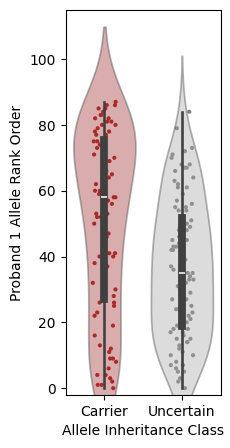

Welch's T-statistic: 3.823854359732902, P-value: 0.00019108200722102014
Median Rank Order for Carrier Alleles: 58.0
Median Rank Order for Uncertain Alleles: 35.0


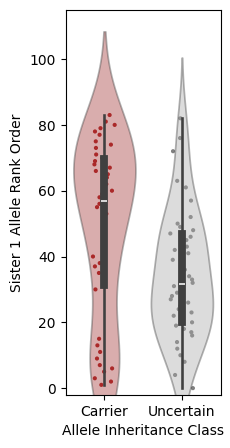

Welch's T-statistic: 2.8016687332790315, P-value: 0.006468351852634062
Median Rank Order for Carrier Alleles: 57.0
Median Rank Order for Uncertain Alleles: 31.5


In [47]:
for plot_type in ['Proband','Sister']:
    file_prefix = f'{plot_type.lower()}1_ro'

    subset_ro_df = total_ro_df[total_ro_df.sample_id.apply(lambda x: plot_type in x)]

    fig,ax = plt.subplots(figsize = (2,5))
    subset_ro_df = subset_ro_df.sort_values(by='allele_class')

    i=sns.violinplot(data=subset_ro_df,x='allele_class',y='sample_rank_order',hue='allele_class',hue_order=['Carrier','Uncertain'],
                palette=['firebrick','darkgrey'],alpha=0.4,legend=False)
    j=sns.stripplot(data=subset_ro_df,x='allele_class',y='sample_rank_order',hue='allele_class',hue_order=['Carrier','Uncertain'],
                dodge=False,jitter=0.15,size=3,palette=['firebrick','grey'],zorder=0)

    ax.set_xlabel('Allele Inheritance Class')
    ax.set_ylabel(f'{plot_type} 1 Allele Rank Order')
    ax.set_ylim(-2,115)

    plt.show()
    fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
    fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
    svg_path = figure_dir/f'{file_prefix}.svg'
    ai_path = figure_dir/f'{file_prefix}.ai'
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the figure as an SVG file
    fig.savefig(svg_path, format="svg",bbox_inches='tight')
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
    plt.close()

    group1 = subset_ro_df[subset_ro_df['allele_class']=='Carrier']['sample_rank_order'].tolist()
    group2 = subset_ro_df[subset_ro_df['allele_class']=='Uncertain']['sample_rank_order'].tolist()
    t_statistic_welch, p_value_welch = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
    with open(figure_dir/f'{file_prefix}_ttest_stats.txt','w') as f:
        f.write(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
        for allele_class in ['Carrier','Uncertain']:
            median_stat = subset_ro_df[subset_ro_df['allele_class']==allele_class]['sample_rank_order'].median()
            print(f'Median Rank Order for {allele_class} Alleles: {median_stat}')
            f.write(f'Median Rank Order for  {allele_class} Alleles: {median_stat}\n')

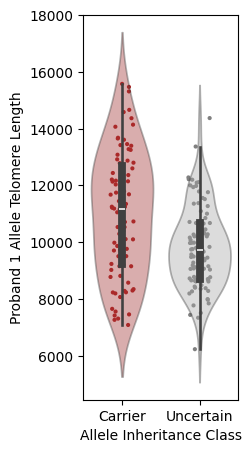

Welch's T-statistic: 4.216547355530132, P-value: 4.4501113637510825e-05
Median Telomere Length for Carrier Alleles: 11188.5
Median Telomere Length for Uncertain Alleles: 9728.75


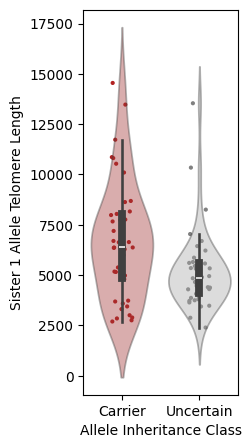

Welch's T-statistic: 2.8424202324372225, P-value: 0.005839318875985527
Median Telomere Length for Carrier Alleles: 6411.375
Median Telomere Length for Uncertain Alleles: 4870.125


In [45]:
for plot_type in ['Proband','Sister']:
    file_prefix = f'{plot_type.lower()}1_tel_len'

    subset_ro_df = total_ro_df[total_ro_df.sample_id.apply(lambda x: plot_type in x)]

    fig,ax = plt.subplots(figsize = (2,5))
    subset_ro_df = subset_ro_df.sort_values(by='allele_class')

    i=sns.violinplot(data=subset_ro_df,x='allele_class',y=f'{operator_for_average}_tel_len',hue='allele_class',hue_order=['Carrier','Uncertain'],
                palette=['firebrick','darkgrey'],alpha=0.4,legend=False)
    j=sns.stripplot(data=subset_ro_df,x='allele_class',y=f'{operator_for_average}_tel_len',hue='allele_class',hue_order=['Carrier','Uncertain'],
                dodge=False,jitter=0.15,size=3,palette=['firebrick','grey'],zorder=0)

    ax.set_xlabel('Allele Inheritance Class')
    ax.set_ylabel(f'{plot_type} 1 Allele Telomere Length')

    plt.show()
    fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
    fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
    svg_path = figure_dir/f'{file_prefix}.svg'
    ai_path = figure_dir/f'{file_prefix}.ai'
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the figure as an SVG file
    fig.savefig(svg_path, format="svg",bbox_inches='tight')
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
    plt.close()

    group1 = subset_ro_df[subset_ro_df['allele_class']=='Carrier'][f'{operator_for_average}_tel_len'].tolist()
    group2 = subset_ro_df[subset_ro_df['allele_class']=='Uncertain'][f'{operator_for_average}_tel_len'].tolist()
    t_statistic_welch, p_value_welch = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
    with open(figure_dir/f'{file_prefix}_ttest_stats.txt','w') as f:
        f.write(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
        for allele_class in ['Carrier','Uncertain']:
            median_stat = subset_ro_df[subset_ro_df['allele_class']==allele_class][f'{operator_for_average}_tel_len'].median()
            print(f'Median Telomere Length for {allele_class} Alleles: {median_stat}')
            f.write(f'Median Telomere Length for {allele_class} Alleles: {median_stat}\n')

Proband 1(a) vs Sister 1 RO Regression:
	Slope: 0.6051110083256244
	R-Value: 0.6051110083256244
	P-Value: 6.62e-06
	Std. Error: 0.1186817094962775

Proband 1(b) vs Sister 1 RO Regression:
	Slope: 0.6075393154486587
	R-Value: 0.6075393154486587
	P-Value: 5.94e-06
	Std. Error: 0.11840570370872953



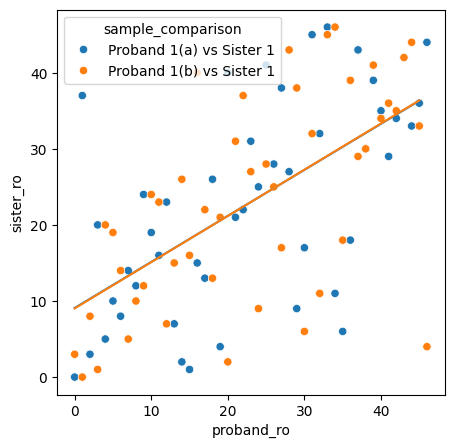

In [16]:
fig,ax = plt.subplots(figsize = (5,5))
i = sns.scatterplot(data=ro_dataframe,x='proband_ro',y='sister_ro',hue='sample_comparison')
for sample_comparison in unique(ro_dataframe.sample_comparison.tolist()):
    x_data = ro_dataframe[ro_dataframe.sample_comparison == sample_comparison].proband_ro.tolist()
    y_data = ro_dataframe[ro_dataframe.sample_comparison == sample_comparison].sister_ro.tolist()

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,y_data)
    line_y = [slope*x+intercept for x in range(round(min(x_data)),round(max(x_data)),round((max(x_data)-min(x_data))/10))]
    if p_value <0.01:
        p_value = "{:.2e}".format(p_value)
    else:
        p_value = str(round(p_value,4))
    j = plt.plot([x for x in range(round(min(x_data)),round(max(x_data)),round((max(x_data)-min(x_data))/10))],line_y)
    print(f'{sample_comparison} RO Regression:')
    print(f'\tSlope: {slope}')
    print(f'\tR-Value: {r_value}')
    print(f'\tP-Value: {p_value}')
    print(f'\tStd. Error: {std_err}\n')
    

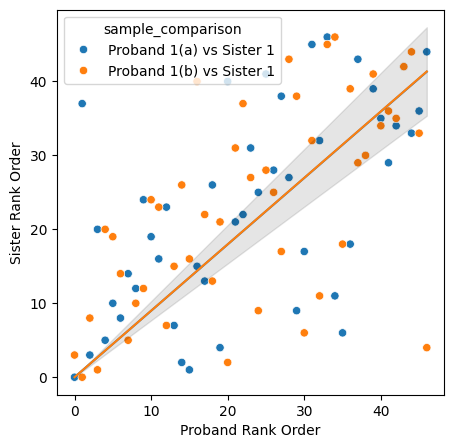

In [17]:

file_prefix = 'fam1_proband_sister_RO_anchored_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass
fig,ax = plt.subplots(figsize = (5,5))
i = sns.scatterplot(data=ro_dataframe,x='proband_ro',y='sister_ro',hue='sample_comparison')
for sample_comparison in unique(ro_dataframe.sample_comparison.tolist()):
    x_data = ro_dataframe[ro_dataframe.sample_comparison == sample_comparison].proband_ro.tolist()
    y_data = ro_dataframe[ro_dataframe.sample_comparison == sample_comparison].sister_ro.tolist()
    # Fit OLS model with NO intercept
    model = sm.OLS(y_data, x_data)
    results = model.fit()
    params = results.params
    ax.plot(x_data, [x * params[0] for x in x_data])

    with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(results.summary().as_text())
confidence_intervals = results.conf_int(alpha=0.05)
lower_bounds = [x * confidence_intervals[0,0] for x in x_data]
upper_bounds = [x * confidence_intervals[0,1] for x in x_data]
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

ax.set_xlabel('Proband Rank Order')
ax.set_ylabel('Sister Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

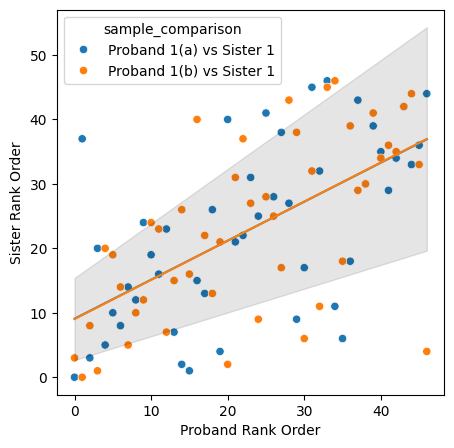

In [18]:
file_prefix = 'fam1_proband_sister_RO_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass
fig,ax = plt.subplots(figsize = (5,5))
i = sns.scatterplot(data=ro_dataframe,x='proband_ro',y='sister_ro',hue='sample_comparison')
for sample_comparison in unique(ro_dataframe.sample_comparison.tolist()):
    x_data = ro_dataframe[ro_dataframe.sample_comparison == sample_comparison].proband_ro.tolist()
    y_data = ro_dataframe[ro_dataframe.sample_comparison == sample_comparison].sister_ro.tolist()
    # Fit OLS model with intercept
    const_x = sm.add_constant(x_data, prepend=False)
    model = sm.OLS(y_data, const_x)
    results = model.fit()
    params = results.params
    slope,intercept = results.params
    ax.plot(x_data, [x * params[0] + params[1] for x in x_data])

    with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
            f.write(results.summary().as_text())
confidence_intervals = results.conf_int(alpha=0.05)
lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_data]
upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_data]
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

ax.set_xlabel('Proband Rank Order')
ax.set_ylabel('Sister Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()



In [19]:
results.f_pvalue

np.float64(5.939972015636311e-06)

In [20]:
carrier_id = unique(patient_key[patient_key.SiblingGroup==1].CarrierParent.to_list())[0]
ro_dataframe['allele_class'] = ro_dataframe.plot_allele_id.apply(lambda x: 'Carrier' if str(family1_df[family1_df.plot_allele_id==x][f'{carrier_id}_tvr_consensus'].item())!='nan' else 'Uncertain')

In [ ]:
proband

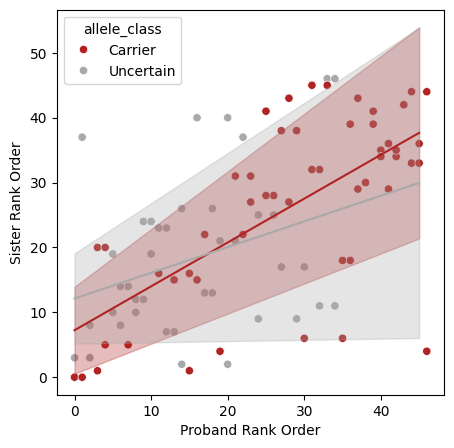

In [13]:
file_prefix = 'fam1_proband_sister_RO_inherit_fit'
custom_colors = ['firebrick','steelblue','darkgrey']
fig,ax = plt.subplots(figsize = (5,5))
i = sns.scatterplot(data=ro_dataframe,x='proband_ro',y='sister_ro',hue='allele_class',palette=['firebrick','darkgrey'])
color_dict = {'Carrier':'firebrick','Uncertain':'darkgrey'}

with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass
xmin = ro_dataframe.proband_ro.min()
xmax = ro_dataframe.proband_ro.max()
plot_xdata = [x for x in range(np.floor(xmin),np.ceil(xmax))]
for sample_comparison in unique(ro_dataframe.allele_class.tolist()):
    x_data = ro_dataframe[ro_dataframe.allele_class == sample_comparison].proband_ro.tolist()
    y_data = ro_dataframe[ro_dataframe.allele_class == sample_comparison].sister_ro.tolist()
    const_x = sm.add_constant(x_data, prepend=False)
    model = sm.OLS(y_data, const_x)
    results = model.fit()
    params = results.params
    ax.plot(plot_xdata, [x * params[0] + params[1] for x in plot_xdata],color=color_dict[sample_comparison])

    with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(results.summary().as_text())
    confidence_intervals = results.conf_int(alpha=0.05)
    lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in plot_xdata]
    upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in plot_xdata]
    k = plt.fill_between(plot_xdata,lower_bounds,upper_bounds,color=color_dict[sample_comparison],alpha=0.3)

ax.set_xlabel('Proband Rank Order')
ax.set_ylabel('Sister Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()